# Evaluation: Discrete Random Variables
## Convergence of Discrete Random Variables

In [24]:
# Libraries
import numpy as np
from matplotlib import pyplot as plt
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "font.size": 14}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
import pymc3 as pm
import seaborn as sns
from functools import reduce
import theano.tensor as tt
from scipy.integrate import quad

import arviz as az
import pandas as pd
import subprocess # for calling leakiest

## Sklearn mutual info implementation
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, SelectKBest


## Scipy entropy/kl-divergence
from scipy.stats import entropy


## Auxiliary functions
def mi_analytical(jm):
    res=0
    py = [sum([jm[x][j] for x in range(len(jm))]) for j in range(len(jm[0]))]
    px = 1/len(jm) # it is uniform
    for i in range(len(jm)):
        for j in range(len(jm[0])):
            res=res+((jm[i][j]*np.log2(jm[i][j]/(px*py[j]))) if jm[i][j] > 0 else 0)
    return res

def trace_mi_analytical(t,s_domain,o_domain):
    res=0
    py=[np.mean(t['output']==j) for j in range(o_domain)]
    for i in range(s_domain):
        px=np.mean(t['secret']==i)
        for j in range(o_domain):
            pxy=np.mean((t['secret']==i) & (t['output']==j))            
            res=res+((pxy*np.log2(pxy/(px*py[j]))) if pxy > 0 else 0)
    return res

## Bayes vulnerability is just the sum of the maximums for each output of the joint distribution (Theorem 5.15, page 83, QIF book)
def bayes_vul(jm):
    res=0
    for j in range(len(jm[0])):        
        res = res + max([jm[x][j] for x in range(len(jm))])
    return res

def trace_bayes_vul(t,s_domain,o_domain):
    res=0
    for j in range(o_domain):        
        res = res + max([np.mean((t['secret']==i) & (t['output']==j)) for i in range(s_domain)])
    return res

## Estimated channel matrix from the trace
def estimated_jm(trace,s_domain,o_domain):    
    jm = [ [ 0 for j in range(o_domain) ] for i in range(s_domain) ]
    for i in range(s_domain):
        for j in range(o_domain):
            jm[i][j]=np.mean((trace['secret']==i) & (trace['output']==j))
    return jm

## Custom mi sklearn function
def mi_sklearn(t,disc_features,n_neigh):
    mi_nat = mutual_info_regression(t['secret'].reshape(-1,1), t['output'], 
                                     discrete_features=disc_features,n_neighbors=n_neigh)
    return mi_nat[0]#/np.log(2)

# Analytical joint matrix (only for adding two numbers model)
def gen_jm(num_secrets):
    num_outputs = (num_secrets*2)-1
    x = list(range(num_secrets))
    jm = [ [ 0 for i in range(num_outputs) ] for j in range(num_secrets) ]
    for i in range(num_secrets):
        for j in range(num_secrets):
            jm[i][i+j]=1/(num_secrets**2)
    return jm

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.11.2


In [2]:
import re
def fbleau_bayes_risk(t):
    #Creating datasets
    df=pd.DataFrame(zip(t['secret'],t['output']),columns=['s','o'])
    tr=int(.8*len(df))
    df_train=df.iloc[:tr]
    df_test=df.iloc[tr:]
    
    # Save datasets as csv
    train_data='fbleau_train.csv'
    test_data='fbleau_test.csv'
    df.to_csv('fbleau.csv',header=False,index=False)
    df_train.to_csv(train_data,header=False,index=False)
    df_test.to_csv(test_data,header=False,index=False)
    
    # Execute fbleau
    fbleau_exec='~/.cargo/bin/fbleau'
    cmd=fbleau_exec+' knn --knn-strategy ln '+train_data+' '+test_data
    stdout=subprocess.check_output(cmd, shell=True, text=True)
    
    # Print output
#     print(stdout)
    return float(re.search('Minimum estimate: (.*)\nMul',stdout).group(1))

In [3]:
def leakiest_mi(t):
    xs=["("+str(x) for x in t['secret']]
    ys=[str(x)+")" for x in t['output']]
    leakiest_data='leakiest.csv'
    pd.Series(ys,xs).to_csv(leakiest_data,header=False)

    leakiest_dir='~/programs/leakiest-1.4.9/'    
    cmd='java -jar '+leakiest_dir+'leakiest-1.4.9.jar -mi -di -o '+leakiest_data+' -v 0'
    stdout=subprocess.check_output(cmd, shell=True, text=True)
#     print(stdout)
    return float(re.search('Estimated mutual information: (.*) \(out',stdout).group(1))

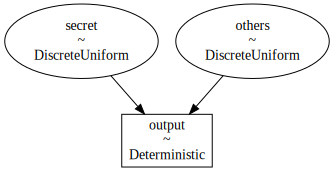

In [20]:
num_secrets=100
with pm.Model() as model:
    N=1
    s=N+1
    secret = pm.DiscreteUniform("secret",lower=0,upper=num_secrets-1)
    others = pm.DiscreteUniform("others",lower=0,upper=num_secrets-1,shape=N)
    output = pm.Deterministic("output",(secret+others.sum()))
pm.model_to_graphviz(model)

In [7]:
with model:
    trace=pm.sample(10000,cores=2,tune=5000)

<ipython-input-7-3c84fad60c4f>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace1000=pm.sample(10000,cores=2,tune=5000)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [others]
>Metropolis: [secret]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Probability queries

In [ ]:
### NOTE: To the probability queries is necessary to build the model with num_secre=1000
###       The trace below is used to compare convergence with secret domain size of 1000
# with model:
#     trace1000=pm.sample(10000,cores=2,tune=5000)

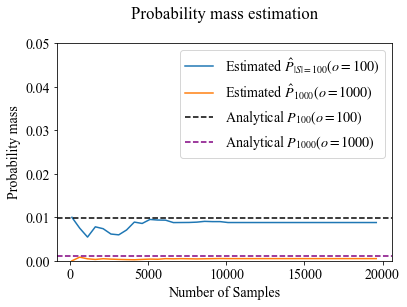

In [12]:
from scipy.stats import randint

def sum_disc_uniforms(x,k,j):
    return sum([randint.pmf(i,0,k)*randint.pmf(x-i,0,j) for i in range(0,k)])

x=np.arange(100, 20000, 500)
y100=[np.mean(trace[:i]['output']==100) for i in x]
y1000=[np.mean(trace1000[:i]['output']==1000) for i in x]
plt.plot(x,y100,label='Estimated $\hat{P}_{|S|=100}(o=100)$')
plt.plot(x,y1000,label='Estimated $\hat{P}_{1000}(o=1000)$')
plt.axhline(y=sum_disc_uniforms(100,100,100), 
            linestyle='--', color='black',  label='Analytical $P_{100}(o=100)$')
plt.axhline(y=sum_disc_uniforms(1000,1000,1000), 
            linestyle='--', color='purple',  label='Analytical $P_{1000}(o=1000)$')
plt.ylim((0.0,0.05))
plt.legend(loc='best')
plt.ylabel('Probability mass')
metric='Number of Samples'
plt.xlabel(metric)
plt.title('Probability mass estimation\n')
plt.show()

### Mutual information

In [22]:
### Build the model with num_secret=100 before executing this cell
assert(num_secrets==100)
with model:
    trace=pm.sample(80000,chains=1,tune=5000)

<ipython-input-22-93024db31e5d>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(80000,chains=1,tune=5000)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [others]
>Metropolis: [secret]


Sampling 1 chain for 5_000 tune and 80_000 draw iterations (5_000 + 80_000 draws total) took 14 seconds.
/home/pardo/.local/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (80000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


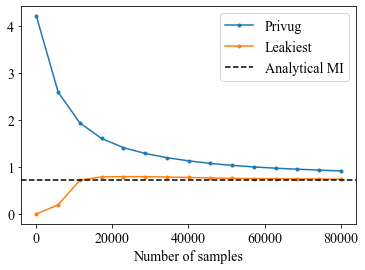

In [27]:
### Build the model with num_secret=100 before executing this cell
assert(num_secrets==100)
x=np.linspace(100,80000,15,dtype=int)
jm=gen_jm(num_secrets)
yprivug_mi=[trace_mi_analytical(trace[-i:],num_secrets,(num_secrets*2)-1) for i in x]
yleakiest=[leakiest_mi(trace[-i:]) for i in x]
plt.plot(x,yprivug_mi, label='Privug', marker='.')
plt.plot(x,yleakiest, label='Leakiest', marker='.')
plt.axhline(y=mi_analytical(jm),
            linestyle='--', color='black',  label='Analytical MI')
plt.legend(loc='best')
plt.xlabel('Number of samples')
plt.show()

### Bayes risk

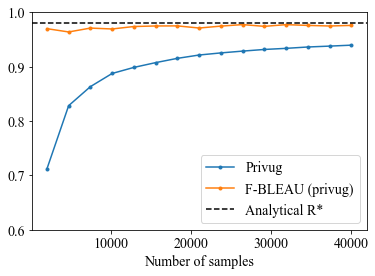

In [29]:
### Make sure that `trace` is sampled with model where num_secret=100 before executing this cell
assert(num_secrets==100)
x=np.linspace(2000,40000,15,dtype=int)
jm=gen_jm(num_secrets)
yprivug=[1-trace_bayes_vul(trace[-i:],num_secrets,(num_secrets*2)-1) for i in x]
yfbleau=[fbleau_bayes_risk(trace[-i:]) for i in x]
plt.plot(x,yprivug, label='Privug', marker='.')
plt.plot(x,yfbleau, label='F-BLEAU (privug)', marker='.')
plt.ylim((0.6,1))
plt.axhline(y=1-bayes_vul(jm),
            linestyle='--', color='black',  label='Analytical R*')
plt.legend(loc='best')
plt.xlabel('Number of samples')
plt.show()

## Scability of Discrete Random Variables

The data below is collected by running the program above with differen number of domain size, i.e., changing the varaible `num_secrets`. Except for the last datapoint (3000,7200) which corresponds to running to the Figaro/Scala model Governor.

| Nr of vars  | Time (s) |
|-------------|----------|
| 10          | 15       |
| 25          | 60       |
| 50          | 150      |
| 75          | 450      |
| 100         | 120      |
| 3000        | 7200     |


Two extra data points scaled from a smaller simulation. This data points are obtained running the Figaro/Scala models Governor and K-anonymity.


| Nr of vars  | Time (s) |
|-------------|----------|
| 2000        | 312000   |
| 75000       | 288000   |


We plot this data together with the regression line they conform.

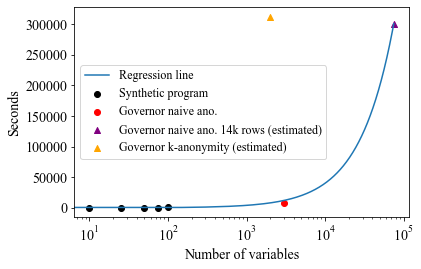

In [14]:
# data
# No. 	x 	y
# 1 	10 	15
# 2 	25 	60
# 3 	50 	150
# 4 	75 	450
# 5 	100 	600
# 6 	3000 	 7200
# 7 	75000 	288000
# extra 	 2000 	 312000

## NOTES: 75000 governor with 14000 rows approximated and multiplied by 10 because we generate only 1000 samples
## NOTES: 500*4 governor k-ano 500 rows approximated and multiplied by 10 because we generate only 1000 samples

## computed from data above (except for the extra data point which corresponds to the k-anonymity algorithm)
A=46.57748
B=4.007
f=lambda x: (B*x)+A
x=np.linspace(0,75000,500)
plt.plot(x,f(x),label='Regression line')

## data points
plt.scatter([10,25,50,75,100],[15,60,150,450,600],
           color='black',label='Synthetic program')
plt.scatter([3000],[7200],
           color='red',label='Governor naive ano.')
plt.scatter([75000],[(8*3600+21*60)*10], # 288000
           color='purple',marker='^',label='Governor naive ano. 14k rows (estimated)')
plt.scatter([500*4],[(8*3600+40*60)*10],
           color='orange',marker='^',label='Governor k-anonymity (estimated)')
plt.xlabel('Number of variables')
plt.ylabel('Seconds')
plt.xscale('log')
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc='best',prop={"size":12})
plt.show()